StateInven_vs_past3YrsNPP_DummyEW_Dec11-for-Dec13

cow_inventory as function of moving average of past 3 years of NPP.

DummyEW: Dummy variable for east vs. western states.

On Dec. 11 Mike and I had a meeting and this decision was made.

In [1]:
import shutup

shutup.please()

import pandas as pd
import numpy as np
from datetime import datetime
import os, os.path, pickle, sys
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from sklearn import preprocessing
import statistics
import statsmodels.api as sm

sys.path.append("/Users/hn/Documents/00_GitHub/Rangeland/Python_Codes/")
import rangeland_core as rc

In [2]:
data_dir_base = "/Users/hn/Documents/01_research_data/RangeLand/Data/"
census_population_dir = data_dir_base + "census/"
# Shannon_data_dir = data_dir_base + "Shannon_Data/"
# USDA_data_dir = data_dir_base + "/NASS_downloads/"
param_dir = data_dir_base + "parameters/"
Min_data_base = data_dir_base + "Min_Data/"
reOrganized_dir = data_dir_base + "reOrganized/"

In [3]:
# for bold print
start_b = "\033[1m"
end_b = "\033[0;0m"
print ("This is " + start_b + "a_bold_text" + end_b + "!")

This is a_bold_text!


# Read

In [4]:
SoI = [
    "Alabama",
    "Arizona",
    "Arkansas",
    "California",
    "Colorado",
    "Florida",
    "Georgia",
    "Idaho",
    "Illinois",
    "Iowa",
    "Kansas",
    "Kentucky",
    "Louisiana",
    "Mississippi",
    "Missouri",
    "Montana",
    "Nebraska",
    "Nevada",
    "New Mexico",
    "North Dakota",
    "Oklahoma",
    "Oregon",
    "South Dakota",
    "Tennessee",
    "Texas",
    "Utah",
    "Virginia",
    "Washington",
    "Wyoming",
]

abb_dict = pd.read_pickle(param_dir + "state_abbreviations.sav")
SoI_abb = []
for x in SoI:
    SoI_abb = SoI_abb + [abb_dict["full_2_abb"][x]]

In [5]:
county_fips = pd.read_pickle(reOrganized_dir + "county_fips.sav")
county_fips = county_fips["county_fips"]
county_fips = county_fips[["state", "state_fip", "EW"]]
county_fips = county_fips[county_fips.state.isin(SoI_abb)].copy()
county_fips.drop_duplicates(inplace=True)
county_fips.reset_index(drop=True, inplace=True)

county_fips.head(2)

,state,state_fip,EW
0,AL,01,E
1,AR,05,E


In [6]:
state_SoI_fip = county_fips.state_fip.unique()
len(state_SoI_fip)

29

In [7]:
# herb = pd.read_csv(data_dir_base + "Supriya/Nov30_herb/state_herb_ratio.csv")
# herb = rc.correct_state_int_fips_to_str(df=herb, col_="state_fip")
# herb.sort_values(by=["state_fip"], inplace=True)
herb = pd.read_pickle(data_dir_base + "Supriya/Nov30_HerbRatio/state_herb_ratio.sav")
print (herb.keys())
herb = herb["state_herb_ratio"]
herb = herb[herb.state_fip.isin(state_SoI_fip)]
# herb.dropna(how="any", inplace=True)
herb.head(3)

dict_keys(['state_herb_ratio', 'source_code', 'Author', 'Date'])


,state_fip,ag_land,pixel_count,herb_avg,herb_std
0,01,131174048583,10874.0,21.019864,25.356867
2,04,294198551143,3704408.0,45.168734,17.311673
3,05,134768872727,24951.0,27.282554,29.379988


In [8]:
herb.dropna(how="any", inplace=True)
herb.reset_index(drop=True, inplace=True)
herb.head(3)

,state_fip,ag_land,pixel_count,herb_avg,herb_std
0,01,131174048583,10874.0,21.019864,25.356867
1,04,294198551143,3704408.0,45.168734,17.311673
2,05,134768872727,24951.0,27.282554,29.379988


### Read Rangeland area and Total area:

In [9]:
# Rangeland area and Total area:
state_RA = pd.read_pickle(reOrganized_dir + "state_RA_area.sav")
state_RA = state_RA["state_RA_area"]
state_RA = state_RA[state_RA.state_fip.isin(state_SoI_fip)]
state_RA.head(2)

,state_fip,rangeland_acre,state_area_acre
0,01,31570.99,14825637.76
1,04,54476918.89,72998287.36


### Read NPP

In [10]:
NPP = pd.read_csv(Min_data_base + "statefips_annual_MODIS_NPP.csv")
NPP.rename(columns={"NPP": "modis_npp", "statefips90m": "state_fip"}, inplace=True)
NPP = rc.correct_3digitStateFips_Min(NPP, "state_fip")

NPP = NPP[NPP.state_fip.isin(state_SoI_fip)]
NPP.reset_index(drop=True, inplace=True)

NPP.head(2)

,year,state_fip,modis_npp
0,2001,01,0.816597
1,2001,04,0.115683


### Convert Unit NPP to State Level

In [11]:
state_NPP_Ra = pd.merge(NPP, state_RA, on=["state_fip"], how="left")
state_NPP_Ra.head(2)

,year,state_fip,modis_npp,rangeland_acre,state_area_acre
0,2001,01,0.816597,31570.99,14825637.76
1,2001,04,0.115683,54476918.89,72998287.36


In [13]:
state_NPP_Ra = rc.covert_unitNPP_2_total(NPP_df=state_NPP_Ra, npp_unit_col_="modis_npp",
                                         acr_area_col_="rangeland_acre", npp_area_col_="state_rangeland_npp")

### Security check to not make mistake later:
state_NPP_Ra.drop(columns=["modis_npp"], inplace=True)
state_NPP_Ra.head(2)

,year,state_fip,rangeland_acre,state_area_acre,area_m2,state_rangeland_npp
0,2001,01,31570.99,14825637.76,1.277635e+08,1.043312e+08
1,2001,04,54476918.89,72998287.36,2.204606e+11,2.550357e+10


### Read Inventory

In [14]:
invent_tall = pd.read_pickle(reOrganized_dir + "Shannon_Beef_Cows_fromCATINV_tall.sav")
invent_tall = invent_tall["CATINV_annual_tall"]

invent_tall = invent_tall[invent_tall.state.isin(SoI_abb)]

invent_tall = invent_tall[invent_tall.year.isin(state_NPP_Ra.year.unique())]
invent_tall.reset_index(drop=True, inplace=True)
invent_tall.head(2)

,state,year,inventory,state_fip
0,AL,2001,737000.0,01
1,AL,2002,750000.0,01


In [15]:
invent_tall_copy = invent_tall.copy()
invent_tall_copy.head(4)

,state,year,inventory,state_fip
0,AL,2001,737000.0,01
1,AL,2002,750000.0,01
2,AL,2003,761000.0,01
3,AL,2004,732000.0,01


In [16]:
col_3NPP = ["NPP_avg_past_3yrs"]

# Add zero in there so that we are using avg of NPP of 2001, 2002, and 2003 for inventory of 2004:
NPP_3yr_avg = list(state_NPP_Ra.state_rangeland_npp.rolling(3).mean())
NPP_3yr_avg.pop()
invent_tall["NPP_avg_past_3yrs"] = [0] + NPP_3yr_avg
invent_tall.head(5)

,state,year,inventory,state_fip,NPP_avg_past_3yrs
0,AL,2001,737000.0,01,0.000000e+00
1,AL,2002,750000.0,01,NaN
2,AL,2003,761000.0,01,NaN
3,AL,2004,732000.0,01,8.565837e+09
4,AL,2005,724000.0,01,2.636689e+10


In [17]:
print (state_NPP_Ra.state_rangeland_npp[:3].values)
print (state_NPP_Ra.state_rangeland_npp[:3].mean())

[1.04331212e+08 2.55035697e+10 8.96112551e+07]
8565837391.773265


In [18]:
invent_tall = invent_tall[invent_tall.year>=2004]
invent_tall.reset_index(drop=True, inplace=True)
invent_tall.head(3)

,state,year,inventory,state_fip,NPP_avg_past_3yrs
0,AL,2004,732000.0,01,8.565837e+09
1,AL,2005,724000.0,01,2.636689e+10
2,AL,2006,686000.0,01,2.764962e+10


## First three years
can be either dropped or drop the first year, and for second year use only 1 year of NPP, and for third year use only 2 years of NPP.

Let's just drop them.

In [19]:
state_RA.head(2)

,state_fip,rangeland_acre,state_area_acre
0,01,31570.99,14825637.76
1,04,54476918.89,72998287.36


In [20]:
invent_tall = pd.merge(invent_tall, state_RA[["state_fip", "rangeland_acre"]], 
                       on=["state_fip"], how="left")

invent_tall = pd.merge(invent_tall, herb[["state_fip", "herb_avg"]], 
                       on=["state_fip"], how="left")

invent_tall = pd.merge(invent_tall, county_fips[["state_fip", "EW"]], 
                       on=["state_fip"], how="left")
invent_tall.head(2)

,state,year,inventory,state_fip,NPP_avg_past_3yrs,rangeland_acre,herb_avg,EW
0,AL,2004,732000.0,01,8.565837e+09,31570.99,21.019864,E
1,AL,2005,724000.0,01,2.636689e+10,31570.99,21.019864,E


In [21]:
invent_tall["EW_binary"] = invent_tall["EW"].map({"E":0, "W" : 1})
invent_tall.head(2)

,state,year,inventory,state_fip,NPP_avg_past_3yrs,rangeland_acre,herb_avg,EW,EW_binary
0,AL,2004,732000.0,01,8.565837e+09,31570.99,21.019864,E,0
1,AL,2005,724000.0,01,2.636689e+10,31570.99,21.019864,E,0


In [22]:
# Re-order the columns.
new_order = ["state_fip", "year", "NPP_avg_past_3yrs", 
             "rangeland_acre", "herb_avg", "EW", "EW_binary", "inventory"]
invent_tall = invent_tall[new_order]
invent_tall.head(2)

,state_fip,year,NPP_avg_past_3yrs,rangeland_acre,herb_avg,EW,EW_binary,inventory
0,01,2004,8.565837e+09,31570.99,21.019864,E,0,732000.0
1,01,2005,2.636689e+10,31570.99,21.019864,E,0,724000.0


In [23]:
invent_tall.tail(2)

,state_fip,year,NPP_avg_past_3yrs,rangeland_acre,herb_avg,EW,EW_binary,inventory
491,56,2019,4.002423e+10,46079514.69,68.307845,W,1,714000.0
492,56,2020,9.648278e+09,46079514.69,68.307845,W,1,724000.0


## Model inventory vs. 3 yrs Avg. NPP.

In [24]:
indp_vars = col_3NPP
y_var = "inventory"

In [25]:
print(invent_tall.year.unique().min())
yr_max = invent_tall.year.unique().max()
print(yr_max)

2004
2020


In [26]:
train_df = invent_tall[invent_tall.year < yr_max].copy()
test_df  = invent_tall[invent_tall.year == yr_max].copy()

In [27]:
train_A = train_df[indp_vars].values
train_A = np.hstack([train_A, np.ones(len(train_A)).reshape(-1, 1)])
print(train_A.shape)
train_y = train_df[y_var].values.reshape(-1).astype("float")

NPP_sol, NPP_RSS, _, _ = np.linalg.lstsq(train_A, train_y)
print (f"{NPP_sol = }")
print (f"{NPP_RSS = }")

######
######   Test
######
test_A = test_df[indp_vars].values
test_A = np.hstack([test_A, np.ones(len(test_A)).reshape(-1, 1)])
y_test = test_df[[y_var]].values.reshape(-1)

yhat_test = test_A @ NPP_sol

NPP_test_res = y_test - yhat_test
NPP_RSS_test = np.dot(NPP_test_res, NPP_test_res)
NPP_MSE_test = NPP_RSS_test / len(y_test)
NPP_RSE_test = np.sqrt(NPP_MSE_test)
print ("========================================================================")
print (start_b + "Test residuals for 3-years-Avg-NPP:\n" + end_b)
print("    RSS_test = {0:.0f}.".format(NPP_RSS_test))
print("    MSE_test = {0:.0f}.".format(NPP_MSE_test))
print("    RSE =  {0:.0f}.".format(NPP_RSE_test))

(464, 2)
NPP_sol = array([4.86074978e-06, 8.91691417e+05])
NPP_RSS = array([3.62022807e+14])
Test residuals for 3-years-Avg-NPP:

    RSS_test = 21808720491453.
    MSE_test = 752024844533.
    RSE =  867194.


In [28]:
X = train_df[indp_vars]
X = sm.add_constant(X)
Y = train_df[y_var].astype(float)
ks = sm.OLS(Y, X)
ks_result =ks.fit()
ks_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inventory   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.189
Date:                Sat, 23 Dec 2023   Prob (F-statistic):              0.140
Time:                        18:44:58   Log-Likelihood:                -7011.2
No. Observations:                 464   AIC:                         1.403e+04
Df Residuals:                     462   BIC:                         1.403e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              8.917e+05   7.97e+04     11.186      0.000    7.35e+05    1.05e+06
NPP_avg_past_3yrs  4.861e-06   3.28e-06      1.480      0.140   -1.59e-06    1.13e-05
==============================================================================
Omnibus:                      293.935   Durbin-Watson:                   0.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2307.919
Skew:                           2.766   Prob(JB):                         0.00
Kurtosis:                      12.422   Cond. No.                     4.71e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
yhat_train = X @ ks_result.params
NPP_train_res = train_df[y_var] - yhat_train
NPP_RSS_train = np.dot(NPP_train_res, NPP_train_res)
NPP_MSE_train = NPP_RSS_train / len(train_df[y_var])
NPP_RSE_train = np.sqrt(NPP_MSE_train)

print (start_b + "train residuals for 3-years-Avg-NPP:\n" + end_b)
print("    RSS_train = {0:.0f}.".format(NPP_RSS_train))
print("    MSE_train = {0:.0f}.".format(NPP_MSE_train))
print("    RSE =  {0:.0f}.".format(NPP_RSE_train))

train residuals for 3-years-Avg-NPP:

    RSS_train = 362022807012055.
    MSE_train = 780221566836.
    RSE =  883302.


In [30]:
test_A = test_df[indp_vars]
test_A = sm.add_constant(test_A)
y_test = test_df[y_var].astype(float)

yhat_test = test_A @ ks_result.params

NPP_test_res = y_test - yhat_test
NPP_RSS_test = np.dot(NPP_test_res, NPP_test_res)
NPP_MSE_test = NPP_RSS_test / len(y_test)
NPP_RSE_test = np.sqrt(NPP_MSE_test)

print (start_b + "Test residuals for 3-years-Avg-NPP:\n" + end_b)
print("    RSS_test = {0:.0f}.".format(NPP_RSS_test))
print("    MSE_test = {0:.0f}.".format(NPP_MSE_test))
print("    RSE =  {0:.0f}.".format(NPP_RSE_test))

Test residuals for 3-years-Avg-NPP:

    RSS_test = 21808720491453.
    MSE_test = 752024844533.
    RSE =  867194.


## Model inventory vs. 3 yrs Avg. NPP, RA, HerbRatio.

In [31]:
indp_vars = col_3NPP + ["rangeland_acre", "herb_avg"]
y_var = "inventory"

In [32]:
indp_vars

['NPP_avg_past_3yrs', 'rangeland_acre', 'herb_avg']

In [33]:
train_df.head(2)

,state_fip,year,NPP_avg_past_3yrs,rangeland_acre,herb_avg,EW,EW_binary,inventory
0,01,2004,8.565837e+09,31570.99,21.019864,E,0,732000.0
1,01,2005,2.636689e+10,31570.99,21.019864,E,0,724000.0


In [34]:
X = train_df[indp_vars]
X = sm.add_constant(X)
Y = train_df[y_var].astype(float)
ks = sm.OLS(Y, X)
ks_result =ks.fit()
ks_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inventory   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     28.60
Date:                Sat, 23 Dec 2023   Prob (F-statistic):           5.65e-17
Time:                        18:45:01   Log-Likelihood:                -6972.6
No. Observations:                 464   AIC:                         1.395e+04
Df Residuals:                     460   BIC:                         1.397e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.664e+05   1.15e+05      3.182      0.002     1.4e+05    5.93e+05
NPP_avg_past_3yrs   3.14e-06   3.04e-06      1.033      0.302   -2.83e-06    9.11e-06
rangeland_acre        0.0121      0.002      6.844      0.000       0.009       0.016
herb_avg           5651.7715   1751.425      3.227      0.001    2209.986    9093.557
==============================================================================
Omnibus:                      165.882   Durbin-Watson:                   0.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              595.345
Skew:                           1.621   Prob(JB):                    5.28e-130
Kurtosis:                       7.504   Cond. No.                     7.37e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
test_A = test_df[indp_vars]
test_A = sm.add_constant(test_A)
y_test = test_df[y_var].astype(float)

yhat_test = test_A @ ks_result.params

NPP_test_res = y_test - yhat_test
NPP_RSS_test = np.dot(NPP_test_res, NPP_test_res)
NPP_MSE_test = NPP_RSS_test / len(y_test)
NPP_RSE_test = np.sqrt(NPP_MSE_test)

print (start_b + "Test residuals for 3-years-Avg-NPP, RA, and herb:\n" + end_b)
print("    RSS_test = {0:.0f}.".format(NPP_RSS_test))
print("    MSE_test = {0:.0f}.".format(NPP_MSE_test))
print("    RSE =  {0:.0f}.".format(NPP_RSE_test))

Test residuals for 3-years-Avg-NPP, RA, and herb:

    RSS_test = 18121712555594.
    MSE_test = 624886639848.
    RSE =  790498.


# Standardize so scales are the same.

In [36]:
print (f"{indp_vars = }")
print ()
train_df.head(2)

indp_vars = ['NPP_avg_past_3yrs', 'rangeland_acre', 'herb_avg']



,state_fip,year,NPP_avg_past_3yrs,rangeland_acre,herb_avg,EW,EW_binary,inventory
0,01,2004,8.565837e+09,31570.99,21.019864,E,0,732000.0
1,01,2005,2.636689e+10,31570.99,21.019864,E,0,724000.0


In [37]:
standard_indp = preprocessing.scale(train_df[indp_vars])

In [38]:
std_cols = [i + j for i, j in zip(indp_vars, ["_standardized"] * len(indp_vars))]
std_cols

['NPP_avg_past_3yrs_standardized',
 'rangeland_acre_standardized',
 'herb_avg_standardized']

In [39]:
train_df[std_cols] = standard_indp
train_df.head(2)

,state_fip,year,NPP_avg_past_3yrs,rangeland_acre,herb_avg,EW,EW_binary,inventory,NPP_avg_past_3yrs_standardized,rangeland_acre_standardized,herb_avg_standardized
0,01,2004,8.565837e+09,31570.99,21.019864,E,0,732000.0,-0.977327,-0.91161,-1.441531
1,01,2005,2.636689e+10,31570.99,21.019864,E,0,724000.0,0.445633,-0.91161,-1.441531


In [40]:
X = train_df[std_cols]
X = sm.add_constant(X)
Y = train_df[y_var].astype(float)
ks = sm.OLS(Y, X)
ks_result =ks.fit()
ks_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inventory   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     28.60
Date:                Sat, 23 Dec 2023   Prob (F-statistic):           5.65e-17
Time:                        18:45:06   Log-Likelihood:                -6972.6
No. Observations:                 464   AIC:                         1.395e+04
Df Residuals:                     460   BIC:                         1.397e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           9.928e+05   3.79e+04     26.196      0.000    9.18e+05    1.07e+06
NPP_avg_past_3yrs_standardized  3.928e+04    3.8e+04      1.033      0.302   -3.54e+04    1.14e+05
rangeland_acre_standardized      2.78e+05   4.06e+04      6.844      0.000    1.98e+05    3.58e+05
herb_avg_standardized           1.307e+05   4.05e+04      3.227      0.001    5.11e+04     2.1e+05
==============================================================================
Omnibus:                      165.882   Durbin-Watson:                   0.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              595.345
Skew:                           1.621   Prob(JB):                    5.28e-130
Kurtosis:                       7.504   Cond. No.                         1.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
yhat_train = X @ ks_result.params
NPP_train_res = train_df[y_var] - yhat_train
NPP_RSS_train = np.dot(NPP_train_res, NPP_train_res)
NPP_MSE_train = NPP_RSS_train / len(train_df[y_var])
NPP_RSE_train = np.sqrt(NPP_MSE_train)

print (start_b + "Standardized: train residuals for 3-years-Avg-NPP, RA, herb:\n" + end_b)
print("    RSS_train = {0:.0f}.".format(NPP_RSS_train))
print("    MSE_train = {0:.0f}.".format(NPP_MSE_train))
print("    RSE =  {0:.0f}.".format(NPP_RSE_train))

Standardized: train residuals for 3-years-Avg-NPP, RA, herb:

    RSS_train = 306554165822011.
    MSE_train = 660677081513.
    RSE =  812820.


# Standardize y and see what happens:

In [42]:
train_y_std = preprocessing.scale(train_y)
NPP_sol, NPP_RSS, _, _ = np.linalg.lstsq(train_A, train_y_std)
print (NPP_sol)
print (NPP_RSS)
print ("==============================================")

yhat_train_std = train_A @ NPP_sol

# kind of un-standardize
yhat_train = (yhat_train_std * np.std(train_y)) + train_y.mean()


NPP_train_res = train_y - yhat_train
NPP_RSS_train = np.dot(NPP_train_res, NPP_train_res)
NPP_MSE_train = NPP_RSS_train / len(train_y)
NPP_RSE_train = np.sqrt(NPP_MSE_train)

print (start_b + "standardized X and Y: train residuals for 3-years-Avg-NPP, RA, Herb, and dummy east-west:\n" + \
       end_b)
print("    RSS_test = {0:.0f}.".format(NPP_RSS_train))
print("    MSE_test = {0:.0f}.".format(NPP_MSE_train))
print("    RSE =  {0:.0f}.".format(NPP_RSE_train))

[ 5.48994055e-12 -1.14147227e-01]
[461.81143684]
standardized X and Y: train residuals for 3-years-Avg-NPP, RA, Herb, and dummy east-west:

    RSS_test = 362022807012054.
    MSE_test = 780221566836.
    RSE =  883302.


# Standard deviation

pandas std(.) and statistics.stdev() both produce the same results using ```N-1``` in denominator while np.std() and preprocessing.scale() use ```N``` in denominator.

In [43]:
# mu = train_df["NPP_avg_past_3yrs"].mean()
# np_std = np.std(train_df["NPP_avg_past_3yrs"])
#### the preprocessing.scale uses np.std. 
#### I do not know why statistics.stdev(.) is different!!!!
# (train_df["NPP_avg_past_3yrs"] - mu) / np_std
# statistics.stdev(train_df["NPP_avg_past_3yrs"])


import statistics

v = train_df["NPP_avg_past_3yrs"]
vcentered = v - v.mean()
vcentered_norm = np.linalg.norm(vcentered)

print (f"{v.std()                          = }")
print (f"{statistics.stdev(v)              = }")
print (f"{vcentered_norm/np.sqrt(len(v)-1) = }")

print()
print (f"{v.std(ddof=0)                    = }")
print (f"{np.std(v)                        = }")
print (f"{vcentered_norm/np.sqrt(len(v))   = }")

v.std()                          = 12523375579.398447
statistics.stdev(v)              = 12523375579.398445
vcentered_norm/np.sqrt(len(v)-1) = 12523375579.398449

v.std(ddof=0)                    = 12509873283.742603
np.std(v)                        = 12509873283.742603
vcentered_norm/np.sqrt(len(v))   = 12509873283.742605


## Model inventory vs. 3 yrs NPP and EW Dummy.

In [42]:
invent_tall.head(2)

,state_fip,year,NPP_avg_past_3yrs,rangeland_acre,herb_avg,EW,EW_binary,inventory
0,01,2004,8.565837e+09,31570.99,21.019864,E,0,732000.0
1,01,2005,2.636689e+10,31570.99,21.019864,E,0,724000.0


In [43]:
indp_vars = col_3NPP + ["EW_binary"]
indp_vars

['NPP_avg_past_3yrs', 'EW_binary']

In [44]:
train_df.head(2)

,state_fip,year,NPP_avg_past_3yrs,rangeland_acre,herb_avg,EW,EW_binary,inventory,NPP_avg_past_3yrs_standardized,rangeland_acre_standardized,herb_avg_standardized
0,01,2004,8.565837e+09,31570.99,21.019864,E,0,732000.0,-0.977327,-0.91161,-1.441531
1,01,2005,2.636689e+10,31570.99,21.019864,E,0,724000.0,0.445633,-0.91161,-1.441531


In [45]:
X = train_df[indp_vars]
X = sm.add_constant(X)
Y = train_df[y_var].astype(float)
ks = sm.OLS(Y, X)
ks_result =ks.fit()
ks_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inventory   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     6.157
Date:                Wed, 13 Dec 2023   Prob (F-statistic):            0.00230
Time:                        15:33:22   Log-Likelihood:                -7006.2
No. Observations:                 464   AIC:                         1.402e+04
Df Residuals:                     461   BIC:                         1.403e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              7.429e+05   9.18e+04      8.093      0.000    5.63e+05    9.23e+05
NPP_avg_past_3yrs  4.618e-06   3.25e-06      1.419      0.157   -1.78e-06     1.1e-05
EW_binary          2.624e+05   8.27e+04      3.175      0.002       1e+05    4.25e+05
==============================================================================
Omnibus:                      275.105   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1972.645
Skew:                           2.571   Prob(JB):                         0.00
Kurtosis:                      11.695   Cond. No.                     6.42e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.42e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
test_A = test_df[indp_vars]
test_A = sm.add_constant(test_A)
y_test = test_df[y_var].astype(float)

yhat_test = test_A @ ks_result.params

NPP_test_res = y_test - yhat_test
NPP_RSS_test = np.dot(NPP_test_res, NPP_test_res)
NPP_MSE_test = NPP_RSS_test / len(y_test)
NPP_RSE_test = np.sqrt(NPP_MSE_test)

print (start_b + "Test residuals for 3-years-NPP-Avg and EW_binary:\n" + end_b)
print("    RSS_test = {0:.0f}.".format(NPP_RSS_test))
print("    MSE_test = {0:.0f}.".format(NPP_MSE_test))
print("    RSE =  {0:.0f}.".format(NPP_RSE_test))

Test residuals for 3-years-NPP-Avg and EW_binary:

    RSS_test = 21077442687677.
    MSE_test = 726808368541.
    RSE =  852531.


## Model inventory vs. 3 yrs NPP, RA, HerbRatio, and EW Dummy.

In [47]:
invent_tall.head(2)

,state_fip,year,NPP_avg_past_3yrs,rangeland_acre,herb_avg,EW,EW_binary,inventory
0,01,2004,8.565837e+09,31570.99,21.019864,E,0,732000.0
1,01,2005,2.636689e+10,31570.99,21.019864,E,0,724000.0


In [48]:
print (invent_tall.NPP_avg_past_3yrs.min())
print (invent_tall.NPP_avg_past_3yrs.max())

2127659909.580448
59185573546.99665


In [49]:
indp_vars = col_3NPP + ["rangeland_acre", "herb_avg", "EW_binary"]
indp_vars

['NPP_avg_past_3yrs', 'rangeland_acre', 'herb_avg', 'EW_binary']

In [50]:
X = train_df[indp_vars]
X = sm.add_constant(X)
Y = train_df[y_var].astype(float)
ks = sm.OLS(Y, X)
ks_result =ks.fit()
ks_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inventory   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     62.93
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           2.16e-42
Time:                        15:33:23   Log-Likelihood:                -6910.9
No. Observations:                 464   AIC:                         1.383e+04
Df Residuals:                     459   BIC:                         1.385e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.048e+05   1.08e+05     -0.966      0.335   -3.18e+05    1.08e+05
NPP_avg_past_3yrs  1.572e-06   2.67e-06      0.590      0.556   -3.67e-06    6.81e-06
rangeland_acre        0.0339      0.002     14.084      0.000       0.029       0.039
herb_avg           2.599e+04   2304.119     11.278      0.000    2.15e+04    3.05e+04
EW_binary         -1.808e+06   1.53e+05    -11.832      0.000   -2.11e+06   -1.51e+06
==============================================================================
Omnibus:                       80.382   Durbin-Watson:                   0.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.606
Skew:                           0.901   Prob(JB):                     1.35e-40
Kurtosis:                       5.500   Cond. No.                     1.18e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
test_A = test_df[indp_vars]
test_A = sm.add_constant(test_A)
y_test = test_df[y_var].astype(float)

yhat_test = test_A @ ks_result.params

NPP_test_res = y_test - yhat_test
NPP_RSS_test = np.dot(NPP_test_res, NPP_test_res)
NPP_MSE_test = NPP_RSS_test / len(y_test)
NPP_RSE_test = np.sqrt(NPP_MSE_test)

print (start_b + "Test residuals for 3-years-NPP-Avg., RA, herb ratio, and dummy east-west:\n" + end_b)
print("    RSS_test = {0:.0f}.".format(NPP_RSS_test))
print("    MSE_test = {0:.0f}.".format(NPP_MSE_test))
print("    RSE =  {0:.0f}.".format(NPP_RSE_test))

Test residuals for 3-years-NPP-Avg., RA, herb ratio, and dummy east-west:

    RSS_test = 14259906890094.
    MSE_test = 491720927245.
    RSE =  701228.


# Transform Variables:

In [52]:
invent_tall.head(2)

,state_fip,year,NPP_avg_past_3yrs,rangeland_acre,herb_avg,EW,EW_binary,inventory
0,01,2004,8.565837e+09,31570.99,21.019864,E,0,732000.0
1,01,2005,2.636689e+10,31570.99,21.019864,E,0,724000.0


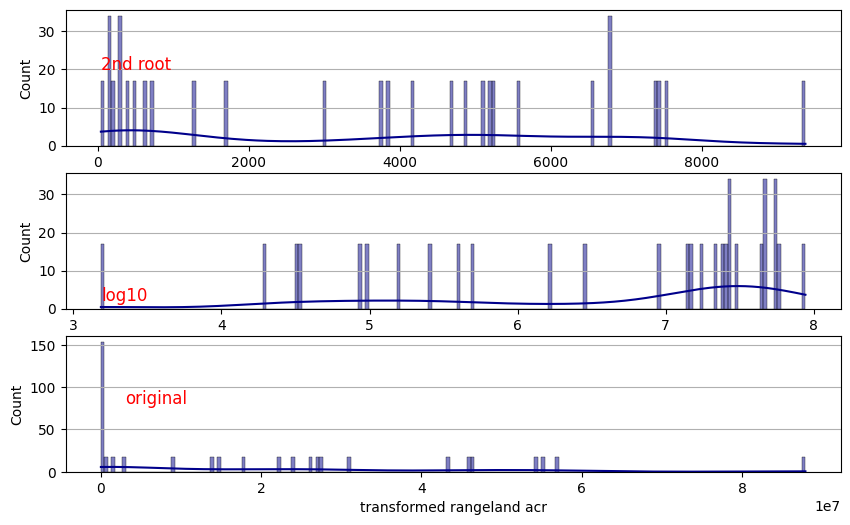

In [53]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharey=False, sharex=False)
axes[0].grid(axis="y", which="both")
axes[1].grid(axis="y", which="both")
axes[2].grid(axis="y", which="both")

text_size, text_color = "large", "r"

data_ = invent_tall.rangeland_acre
sns.histplot(data=np.sqrt(data_), kde=True, bins=200, color="darkblue", ax=axes[0])
axes[0].text(x=np.sqrt(data_).min() + 2, y=20, s="2nd root", fontsize=text_size, color=text_color)

###########################################
sns.histplot(data=np.log10(data_), kde=True, bins=200, color="darkblue", ax=axes[1])
axes[1].text(x=np.log10(data_).min(), y=2, s="log10", fontsize=text_size, color=text_color)

###########################################
# sns.histplot(data = 1/data_, kde = True, bins=200, color = 'darkblue', ax=axes[2]);
# axes[2].text(x = (1/data_).min(), y=200, s='inverse', fontsize=text_size, color=text_color)

sns.histplot(data=data_, kde=True, bins=200, color="darkblue", ax=axes[2])
axes[2].text(x=data_.min() + 3000000, y=80, s="original", fontsize=text_size, color=text_color)


axes[0].set_xlabel("");
axes[1].set_xlabel("");
axes[2].set_xlabel("transformed rangeland acr");

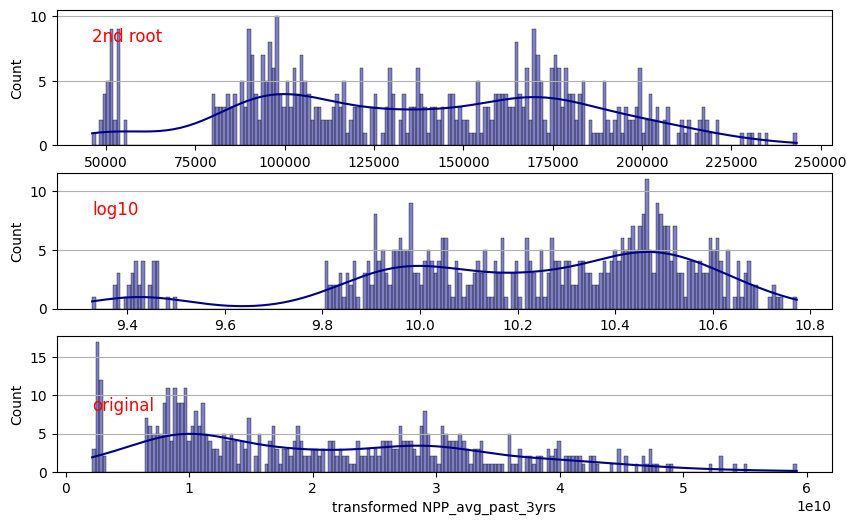

In [54]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharey=False, sharex=False)
axes[0].grid(axis="y", which="both")
axes[1].grid(axis="y", which="both")
axes[2].grid(axis="y", which="both")

text_size, text_color = "large", "r"

data_ = invent_tall.NPP_avg_past_3yrs
sns.histplot(data=np.sqrt(data_), kde=True, bins=200, color="darkblue", ax=axes[0])
axes[0].text(x=np.sqrt(data_).min() + 2, y=8, s="2nd root", fontsize=text_size, color=text_color)

###########################################
sns.histplot(data=np.log10(data_), kde=True, bins=200, color="darkblue", ax=axes[1])
axes[1].text(x=np.log10(data_).min(), y=8, s="log10", fontsize=text_size, color=text_color)

###########################################
# sns.histplot(data = 1/data_, kde = True, bins=200, color = 'darkblue', ax=axes[2]);
# axes[2].text(x = (1/data_).min(), y=200, s='inverse', fontsize=text_size, color=text_color)

sns.histplot(data=data_, kde=True, bins=200, color="darkblue", ax=axes[2])
axes[2].text(x=data_.min() + 3000000, y=8, s="original", fontsize=text_size, color=text_color)


axes[0].set_xlabel("");
axes[1].set_xlabel("");
axes[2].set_xlabel("transformed NPP_avg_past_3yrs");

### Avg. of current year and past 3 years (4 years total):


#### Model inventory vs. 4 yrs NPP avg, RA, HerbRatio, and EW Dummy.



In [55]:
invent_tall_copy.head(4)

,state,year,inventory,state_fip
0,AL,2001,737000.0,01
1,AL,2002,750000.0,01
2,AL,2003,761000.0,01
3,AL,2004,732000.0,01


In [56]:
col_3NPP = ["NPP_avg_past_4yrs"]

# Add zero in there so that we are using avg of NPP of 2001, 2002, and 2003 for inventory of 2004:
NPP_4yr_avg = list(state_NPP_Ra.state_rangeland_npp.rolling(4).mean())
invent_tall_copy["NPP_avg_past_4yrs"] = NPP_4yr_avg
invent_tall_copy.head(5)

,state,year,inventory,state_fip,NPP_avg_past_4yrs
0,AL,2001,737000.0,01,NaN
1,AL,2002,750000.0,01,NaN
2,AL,2003,761000.0,01,NaN
3,AL,2004,732000.0,01,1.980125e+10
4,AL,2005,724000.0,01,2.711311e+10


In [57]:
print (state_NPP_Ra.state_rangeland_npp[:4].values)
print (state_NPP_Ra.state_rangeland_npp[:4].mean())

[1.04331212e+08 2.55035697e+10 8.96112551e+07 5.35074758e+10]
19801246992.66378


In [58]:
invent_tall_copy = invent_tall_copy[invent_tall_copy.year>=2004]
invent_tall_copy.reset_index(drop=True, inplace=True)
invent_tall_copy.head(3)

,state,year,inventory,state_fip,NPP_avg_past_4yrs
0,AL,2004,732000.0,01,1.980125e+10
1,AL,2005,724000.0,01,2.711311e+10
2,AL,2006,686000.0,01,2.199293e+10


In [59]:
invent_tall_copy = pd.merge(invent_tall_copy, state_RA[["state_fip", "rangeland_acre"]], 
                            on=["state_fip"], how="left")

invent_tall_copy = pd.merge(invent_tall_copy, herb[["state_fip", "herb_avg"]], 
                            on=["state_fip"], how="left")

invent_tall_copy = pd.merge(invent_tall_copy, county_fips[["state_fip", "EW"]], 
                             on=["state_fip"], how="left")

invent_tall_copy.head(2)

,state,year,inventory,state_fip,NPP_avg_past_4yrs,rangeland_acre,herb_avg,EW
0,AL,2004,732000.0,01,1.980125e+10,31570.99,21.019864,E
1,AL,2005,724000.0,01,2.711311e+10,31570.99,21.019864,E


In [60]:
invent_tall_copy["EW_binary"] = invent_tall_copy["EW"].map({"E":0, "W" : 1})
invent_tall_copy.head(2)

,state,year,inventory,state_fip,NPP_avg_past_4yrs,rangeland_acre,herb_avg,EW,EW_binary
0,AL,2004,732000.0,01,1.980125e+10,31570.99,21.019864,E,0
1,AL,2005,724000.0,01,2.711311e+10,31570.99,21.019864,E,0


In [61]:
# Re-order the columns.
new_order = ["state_fip", "year", "NPP_avg_past_4yrs", 
             "rangeland_acre", "herb_avg", "EW", "EW_binary", "inventory"]
invent_tall_copy = invent_tall_copy[new_order]
invent_tall_copy.head(2)

,state_fip,year,NPP_avg_past_4yrs,rangeland_acre,herb_avg,EW,EW_binary,inventory
0,01,2004,1.980125e+10,31570.99,21.019864,E,0,732000.0
1,01,2005,2.711311e+10,31570.99,21.019864,E,0,724000.0


In [62]:
indp_vars = col_3NPP + ["rangeland_acre", "herb_avg", "EW_binary"]
print (f"{yr_max = }")
indp_vars

['NPP_avg_past_4yrs', 'rangeland_acre', 'herb_avg', 'EW_binary']

In [64]:
train_df = invent_tall_copy[invent_tall_copy.year < yr_max].copy()
test_df  = invent_tall_copy[invent_tall_copy.year == yr_max].copy()

In [65]:
train_A = train_df[indp_vars].values
train_A = np.hstack([train_A, np.ones(len(train_A)).reshape(-1, 1)])
print(train_A.shape)

train_y = train_df[y_var].values.reshape(-1).astype("float")
train_df.head(3)

(464, 5)


In [67]:
NPP_sol, NPP_RSS, _, _ = np.linalg.lstsq(train_A, train_y)
print (indp_vars)
NPP_sol

['NPP_avg_past_4yrs', 'rangeland_acre', 'herb_avg', 'EW_binary']


array([ 1.08180723e-06,  3.39766095e-02,  2.59928116e+04, -1.80881006e+06,
       -9.53617919e+04])

In [68]:
test_A = test_df[indp_vars].values
test_A = np.hstack([test_A, np.ones(len(test_A)).reshape(-1, 1)])
y_test = test_df[[y_var]].values.reshape(-1)

yhat_test = test_A @ NPP_sol

NPP_test_res = y_test - yhat_test
NPP_RSS_test = np.dot(NPP_test_res, NPP_test_res)
NPP_MSE_test = NPP_RSS_test / len(y_test)
NPP_RSE_test = np.sqrt(NPP_MSE_test)


print (start_b + "Test residuals for 4-years-NPP-Avg., RA, herb ratio, and dummy EW:\n" + end_b)
print("    RSS_test = {0:.0f}.".format(NPP_RSS_test))
print("    MSE_test = {0:.0f}.".format(NPP_MSE_test))
print("    RSE =  {0:.0f}.".format(NPP_RSE_test))

Test residuals for 4-years-NPP-Avg., RA, herb ratio, and dummy EW:

    RSS_test = 14198413999618.
    MSE_test = 489600482745.
    RSE =  699715.
